In [21]:
import os

Training

In [22]:
!python train.py \
    --data_dir ./data_demo \
    --model_save_dir ./models \
    --epochs 10 \
    --batch_size 8 \
    --learning_rate 0.001 \
    --patch_size 512 \
    --use_avgexp \

/home1/liuwy/miniconda3/envs/ghist/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Using device: cpu
Loading all data files...
AvgExp reference: (63, 313)
Nuclei segmentation image size: (5120, 5120)
Loading TIFF with tifffile: ./data_demo/he_image.tif
Successfully loaded TIFF with shape: (5120, 5120, 3)
Cell-gene matrix: (5508, 280)
Target genes: 280
Cell types: (5508, 1)
Matched nuclei: 5508
Found 9517 cells in segmentation image
Cell type mapping: {'T': 0, 'Macrophage': 1, 'Fibroblast': 2, 'Endothelial': 3, 'Plasma': 4, 'Myeloid': 5, 'B': 6, 'Epithelial': 7, 'Malignant': 8}
Common cells across 

validation

In [30]:
!python inference.py --checkpoint models/best_model.pth --data_dir data_demo

/home1/liuwy/miniconda3/envs/ghist/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Using device: cpu
Loading validation dataset...
Loading all data files...
AvgExp reference: (63, 313)
Nuclei segmentation image size: (5120, 5120)
Loading TIFF with tifffile: data_demo/he_image.tif
Successfully loaded TIFF with shape: (5120, 5120, 3)
Cell-gene matrix: (5508, 280)
Target genes: 280
Cell types: (5508, 1)
Matched nuclei: 5508
Found 9517 cells in segmentation image
Cell type mapping: {'T': 0, 'Macrophage': 1, 'Fibroblast': 2, 'Endothelial': 3, 'Plasma': 4, 'Myeloid': 5, 'B': 6, 'Epithelial': 7, 'Maligna

In [ ]:
sample: CryoNuSeg

In [44]:
!python predict.py \
    --checkpoint ./models/best_model.pth \
    --he_image ./data_demo/he_image.tif \
    --nuclei_seg ./data_demo/he_image_nuclei_seg.tif \
    --output_dir ./demo/sample/predictions 

Using device: cpu
Loading images...
H&E: (5120, 5120, 3), Nuclei: (5120, 5120)
Cells detected: 5059219
Loading GHIST model from ./models/best_model.pth
Model config: 280 genes
Loaded 17 expression-related parameters
Starting gene expression prediction...
Preparing patches...
Found 400 patches with cells
Predicting gene expression for 400 patches...
Predicting: 100%|█████████████████████████████| 400/400 [00:24<00:00, 16.49it/s]
Saving results...
Prediction completed!
- Cells: 11104
- Genes: 280
- Output: ./demo/sample/predictions/ghist_predictions.csv


In [46]:
import pandas as pd

# 读取基因名
with open('./demo/sample/genes.txt', 'r') as f:
    genes = [line.strip() for line in f.readlines() if line.strip()]

print(f"读取到 {len(genes)} 个基因名")

# 读取CSV文件
df = pd.read_csv('./demo/sample/predictions/ghist_predictions.csv')

# 检查基因数量是否匹配
if len(genes) != (len(df.columns) - 2):  # 减去x,y列
    print(f"警告: 基因数量不匹配 - genes.txt: {len(genes)}, CSV基因列: {len(df.columns)-2}")
else:
    # 替换列名：前两列保持不变，后面的列替换为基因名
    new_columns = list(df.columns[:2]) + genes
    df.columns = new_columns
    
    # 保存结果
    df.to_csv('ghist_predictions_renamed.csv', index=False)
    print("列名替换完成，结果已保存为 ghist_predictions_renamed.csv")
    
    # 显示前几列作为验证
    print("\n前几列预览:")
    print(df.columns[:10])

读取到 280 个基因名
列名替换完成，结果已保存为 ghist_predictions_renamed.csv

前几列预览:
Index(['x', 'y', 'ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5', 'ADH1B',
       'ADIPOQ', 'AGR3'],
      dtype='object')


细胞类型注释，使用的celltypist

In [50]:
ghist_data = pd.read_csv('./demo/sample/predictions/ghist_predictions_renamed.csv')
labels_data = pd.read_csv('./demo/sample/predictions/predicted_labels.csv')

# 检查列名
print("predicted_labels.csv的列名:", labels_data.columns.tolist())

cell_type_column = labels_data.columns[1]  # 获取第二列的列名

# 检查行数是否匹配
if len(ghist_data) != len(labels_data):
    print(f"警告: 两个文件行数不匹配 - ghist: {len(ghist_data)}, labels: {len(labels_data)}")
    
    # 如果只是差一行，可能是表头问题，我们可以尝试去掉第一行
    if len(labels_data) - len(ghist_data) == 1:
        print("可能是表头问题，跳过第一行")
        labels_data = labels_data.iloc[1:].reset_index(drop=True)
else:
    print(f"文件行数匹配: {len(ghist_data)} 行")

# 再次检查行数
if len(ghist_data) == len(labels_data):
    # 将细胞类型列添加到ghist数据中
    ghist_data['cell_type'] = labels_data[cell_type_column]
    
    # 保存合并后的文件
    ghist_data.to_csv('ghist_predictions_with_celltypes.csv', index=False)
    print("合并完成！结果保存为 ghist_predictions_with_celltypes.csv")
    
    # 显示细胞类型分布
    print("\n细胞类型分布:")
    cell_type_counts = ghist_data['cell_type'].value_counts()
    print(cell_type_counts)
    
    # 显示前几行数据作为验证
    print("\n前5行数据预览:")
    print(ghist_data[['x', 'y', 'cell_type']].head())
else:
    print(f"行数仍然不匹配，无法合并")
    print(f"ghist: {len(ghist_data)}, labels: {len(labels_data)}")

predicted_labels.csv的列名: ['Unnamed: 0', 'predicted_labels', 'over_clustering', 'majority_voting']
文件行数匹配: 11104 行
合并完成！结果保存为 ghist_predictions_with_celltypes.csv

细胞类型分布:
cell_type
Lymph-valve2       9332
basal              1325
Neutrophil          194
Macro-IFN           178
bmem_unswitched      47
Lumsec-myo           28
Name: count, dtype: int64

前5行数据预览:
            x           y     cell_type
0  235.504808    4.000000  Lymph-valve2
1  210.533333    4.911111     Macro-IFN
2  173.913934   42.741803     Macro-IFN
3  235.054399   67.022163    Lumsec-myo
4  189.125000  103.026786  Lymph-valve2


H&E图像尺寸: (5120, 5120, 3)
数据坐标范围: X(0.33, 5119.00), Y(0.00, 5119.00)
图像尺寸: 5120 x 5120


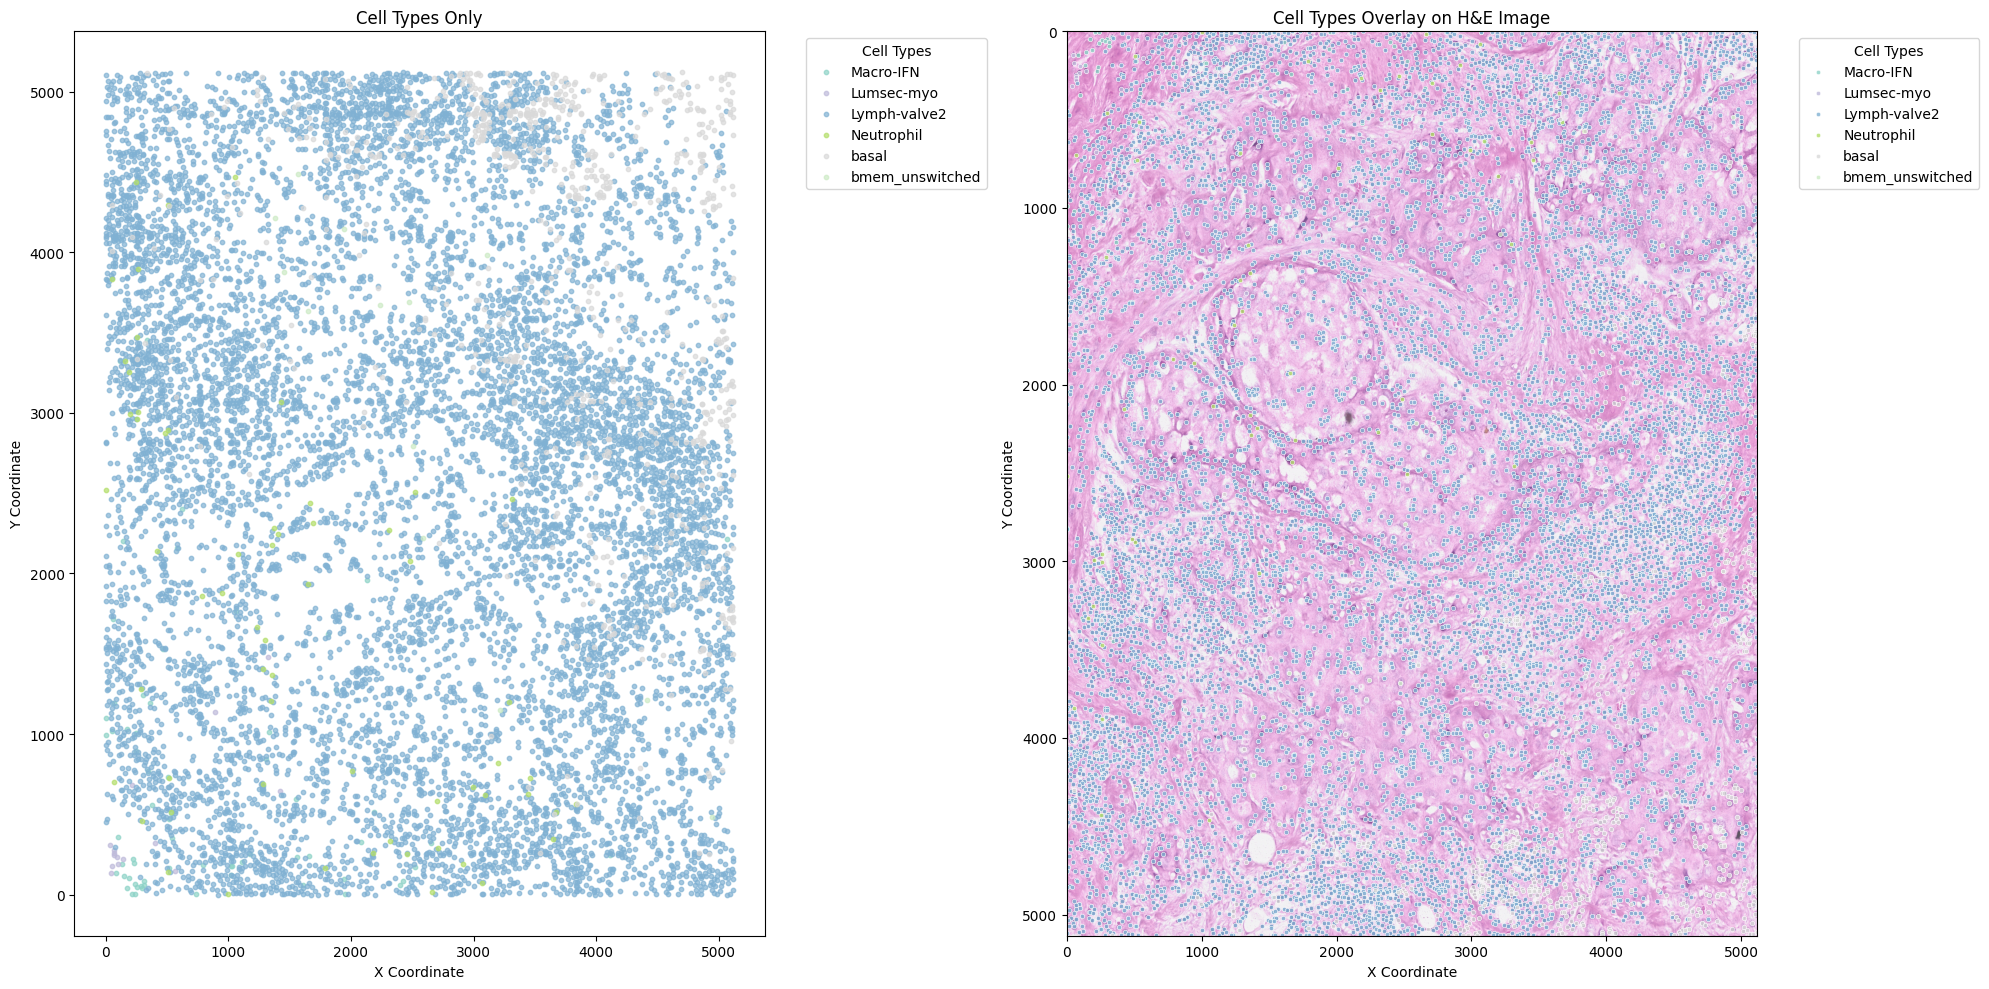

模拟细胞类型分布:
cell_type_smoothed
Lymph-valve2       10213
basal                736
Macro-IFN             66
Neutrophil            61
Lumsec-myo            15
bmem_unswitched       13
Name: count, dtype: int64


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# 读取数据
data = pd.read_csv('./data_demo/celltype_filtered.csv')

# 读取H&E图像
he_image_path = './data_demo/he_image.tif'
if os.path.exists(he_image_path):
    he_image = Image.open(he_image_path)
    he_array = np.array(he_image)
    print(f"H&E图像尺寸: {he_array.shape}")
    
    # 获取图像尺寸
    img_height, img_width = he_array.shape[:2]
    
    # 获取数据坐标范围
    x_min, x_max = data['x'].min(), data['x'].max()
    y_min, y_max = data['y'].min(), data['y'].max()
    
    print(f"数据坐标范围: X({x_min:.2f}, {x_max:.2f}), Y({y_min:.2f}, {y_max:.2f})")
    print(f"图像尺寸: {img_width} x {img_height}")
    
    # 如果需要，调整坐标以匹配图像尺寸
    if x_max > img_width or y_max > img_height:
        print("调整坐标以匹配图像尺寸...")
        # 将数据坐标缩放到图像尺寸
        data['x_scaled'] = (data['x'] - x_min) / (x_max - x_min) * img_width
        data['y_scaled'] = (data['y'] - y_min) / (y_max - y_min) * img_height
        x_col, y_col = 'x_scaled', 'y_scaled'
    else:
        x_col, y_col = 'x', 'y'
        
else:
    print(f"警告: 找不到H&E图像文件 {he_image_path}")
    he_array = None
    x_col, y_col = 'x', 'y'

# 获取细胞类型和颜色映射
cell_types = data['cell_type_smoothed'].unique()
type_to_idx = {t: i for i, t in enumerate(cell_types)}

# 创建图形
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 左侧：仅散点图
for cell_type in cell_types:
    subset = data[data['cell_type_smoothed'] == cell_type]
    axes[0].scatter(subset[x_col], subset[y_col], 
                   c=[plt.cm.Set3(type_to_idx[cell_type]/len(cell_types))], 
                   label=cell_type, s=10, alpha=0.7)

axes[0].set_title('Cell Types Only')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

# 右侧：叠加在H&E图像上
if he_array is not None:
    # 显示H&E图像
    axes[1].imshow(he_array, aspect='auto', alpha=0.7)
    
    # 叠加散点图
    for cell_type in cell_types:
        subset = data[data['cell_type_smoothed'] == cell_type]
        axes[1].scatter(subset[x_col], subset[y_col], 
                       c=[plt.cm.Set3(type_to_idx[cell_type]/len(cell_types))], 
                       label=cell_type, s=10, alpha=0.8, edgecolors='white', linewidth=0.5)
    
    axes[1].set_title('Cell Types Overlay on H&E Image')
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Y Coordinate')
    axes[1].legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 设置坐标轴范围以匹配图像
    axes[1].set_xlim(0, img_width)
    axes[1].set_ylim(img_height, 0)  # 注意：图像坐标原点在左上角
else:
    axes[1].text(0.5, 0.5, 'H&E Image Not Found', 
                horizontalalignment='center', verticalalignment='center',
                transform=axes[1].transAxes, fontsize=16)
    axes[1].set_title('H&E Image Not Available')

plt.tight_layout()
plt.savefig('cell_types_on_he_image.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印细胞类型统计
print("模拟细胞类型分布:")
print(data['cell_type_smoothed'].value_counts())

H&E图像尺寸: (5120, 5120, 3)


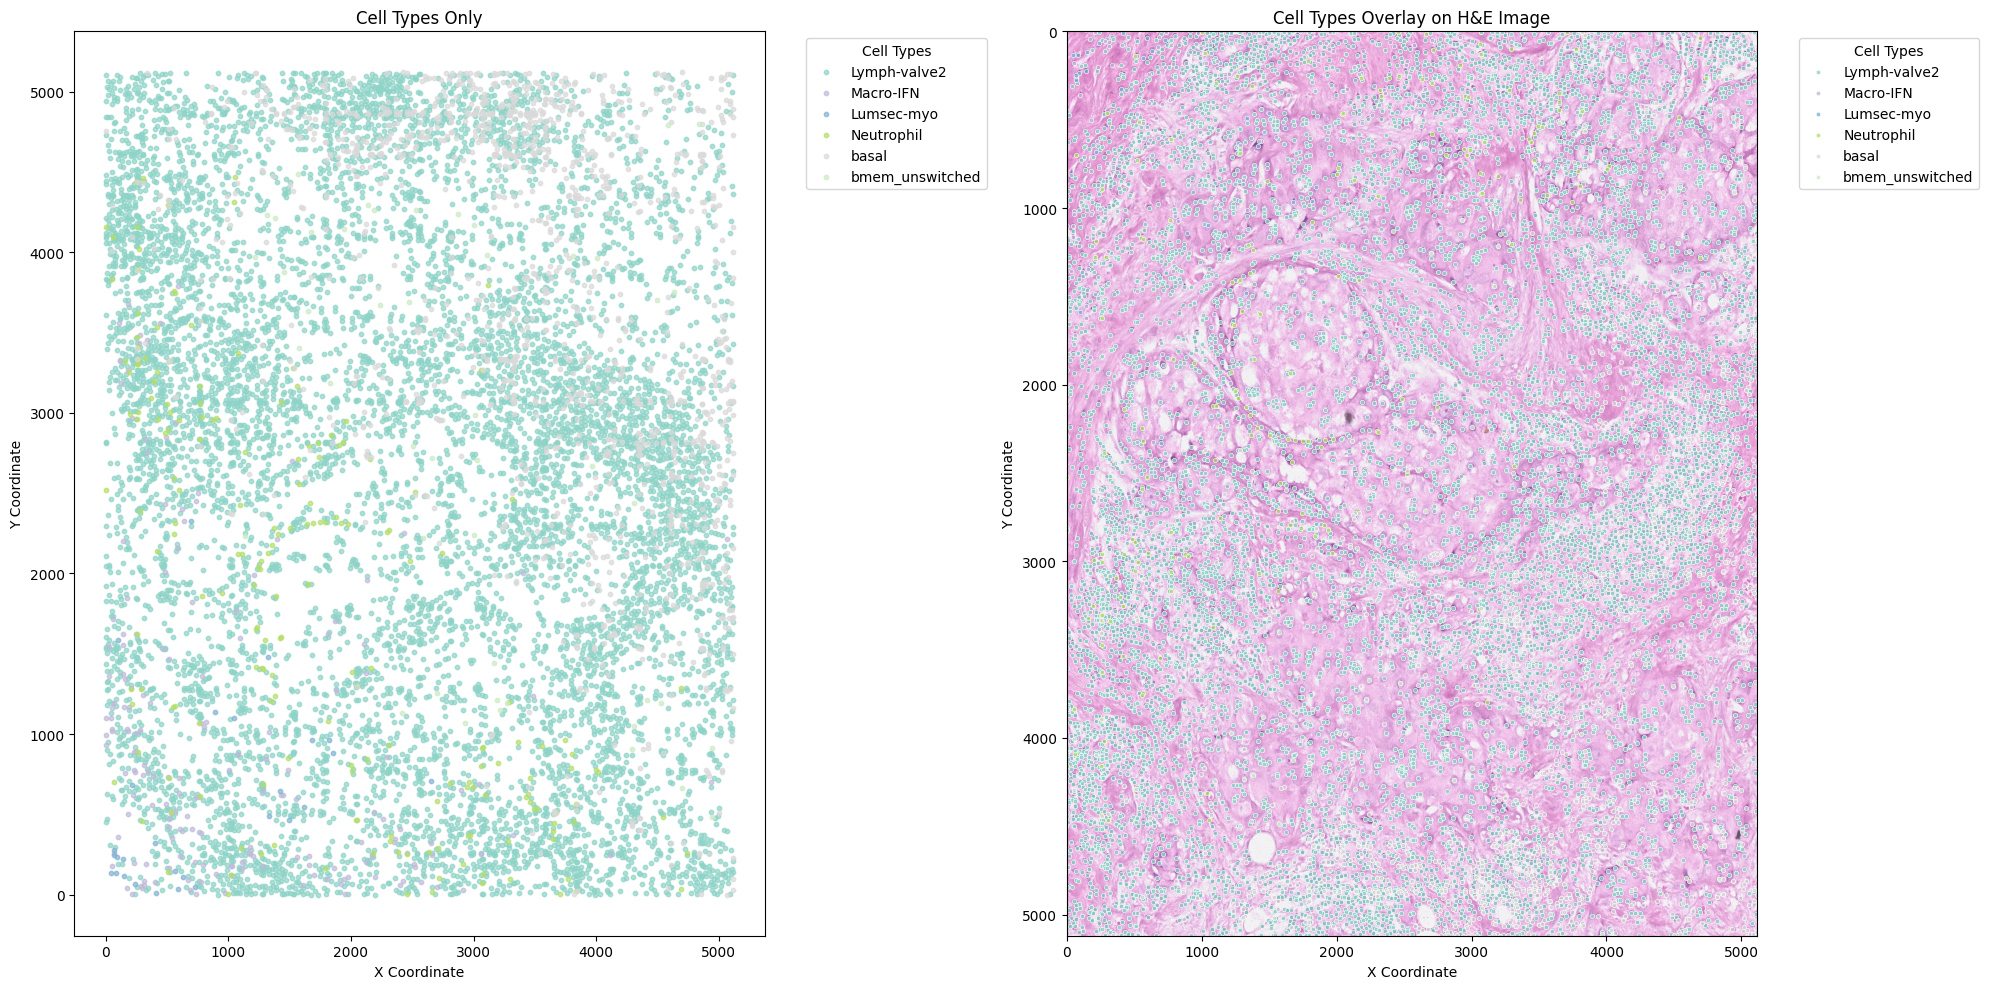

模拟细胞类型分布:
cell_type
Lymph-valve2       9332
basal              1325
Neutrophil          194
Macro-IFN           178
bmem_unswitched      47
Lumsec-myo           28
Name: count, dtype: int64


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# 读取数据
data = pd.read_csv('./demo/sample/predictions/ghist_predictions_with_celltypes.csv')  # 使用之前生成的平滑数据

# 读取H&E图像
he_image_path = './data_demo/he_image.tif'
if os.path.exists(he_image_path):
    he_image = Image.open(he_image_path)
    he_array = np.array(he_image)
    print(f"H&E图像尺寸: {he_array.shape}")
else:
    print(f"警告: 找不到H&E图像文件 {he_image_path}")
    he_array = None

# 获取细胞类型和颜色映射
cell_types = data['cell_type'].unique()
type_to_idx = {t: i for i, t in enumerate(cell_types)}

# 创建图形
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 左侧：仅散点图
for cell_type in cell_types:
    subset = data[data['cell_type'] == cell_type]
    axes[0].scatter(subset['x'], subset['y'], 
                   c=[plt.cm.Set3(type_to_idx[cell_type]/len(cell_types))], 
                   label=cell_type, s=10, alpha=0.7)

axes[0].set_title('Cell Types Only')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

# 右侧：叠加在H&E图像上
if he_array is not None:
    # 显示H&E图像
    axes[1].imshow(he_array, aspect='auto', alpha=0.7)
    
    # 叠加散点图
    for cell_type in cell_types:
        subset = data[data['cell_type'] == cell_type]
        axes[1].scatter(subset['x'], subset['y'], 
                       c=[plt.cm.Set3(type_to_idx[cell_type]/len(cell_types))], 
                       label=cell_type, s=10, alpha=0.8, edgecolors='white', linewidth=0.5)
    
    axes[1].set_title('Cell Types Overlay on H&E Image')
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Y Coordinate')
    axes[1].legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    axes[1].text(0.5, 0.5, 'H&E Image Not Found', 
                horizontalalignment='center', verticalalignment='center',
                transform=axes[1].transAxes, fontsize=16)
    axes[1].set_title('H&E Image Not Available')

plt.tight_layout()
plt.savefig('cell_types_on_he_image.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印细胞类型统计
print("模拟细胞类型分布:")
print(data['cell_type'].value_counts())